In [1]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
import statsmodels.api as sm

from src.visualization.charts import ModelCharts
from src.visualization.metrics import PredictionEvaluator, GlobalResults
from src.config import Config

## Load the data

In [2]:
config = Config()
variant_co2 = 'co2_per_capita'
x_train_df = pd.read_csv(os.path.join(config.output_cleaned_arimax, f'{variant_co2}/exog_train.csv')).set_index(['year'])
x_test_df = pd.read_csv(os.path.join(config.output_cleaned_arimax, f'{variant_co2}/exog_test.csv')).set_index(['year'])

y_train_df = pd.read_csv(os.path.join(config.output_cleaned_arimax, f'{variant_co2}/y_train.csv')).set_index(['year'])
y_test_df = pd.read_csv(os.path.join(config.output_cleaned_arimax, f'{variant_co2}/y_test.csv')).set_index(['year'])


In [3]:
x_train_df

,country_order,country_index,gdp_lag_1,gdp_lag_2,temperature_change_from_co2_lag_1,temperature_change_from_co2_lag_2,cement_co2_lag_1,cement_co2_lag_2,coal_co2_lag_1,coal_co2_lag_2,flaring_co2_lag_1,flaring_co2_lag_2,gas_co2_lag_1,gas_co2_lag_2,land_use_change_co2_lag_1,land_use_change_co2_lag_2,oil_co2_lag_1,oil_co2_lag_2
year,,,,,,,,,,,,,,,,,,
1853,0,Stany Zjednoczone,4001.399409,3793.193144,3.993500e-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000001,0.000001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.651469e-05,3.545073e-05,0.000000,0.000000
1854,0,Stany Zjednoczone,4302.327650,4001.399409,3.876999e-11,3.993500e-11,0.000000e+00,0.000000e+00,0.000001,0.000001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.586453e-05,3.651469e-05,0.000000,0.000000
1855,0,Stany Zjednoczone,4304.295488,4302.327650,7.527797e-11,3.876999e-11,0.000000e+00,0.000000e+00,0.000001,0.000001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.624544e-05,3.586453e-05,0.000000,0.000000
1856,0,Stany Zjednoczone,4213.411261,4304.295488,7.308195e-11,7.527797e-11,0.000000e+00,0.000000e+00,0.000001,0.000001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.560530e-05,3.624544e-05,0.000000,0.000000
1857,0,Stany Zjednoczone,4299.779628,4213.411261,7.095000e-11,7.308195e-11,0.000000e+00,0.000000e+00,0.000001,0.000001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.564216e-05,3.560530e-05,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,44,Szwecja,28521.708437,27507.857018,2.265955e-10,2.277854e-10,1.468339e-07,1.263070e-07,0.000001,0.000001,3.818135e-08,3.359835e-08,2.335067e-07,2.308605e-07,-6.565606e-07,-1.105443e-06,0.000005,0.000005
1997,44,Szwecja,29014.635719,28521.708437,2.262359e-10,2.265955e-10,1.385695e-07,1.468339e-07,0.000001,0.000001,3.642398e-08,3.818135e-08,2.515743e-07,2.335067e-07,-8.620720e-07,-6.565606e-07,0.000005,0.000005
1998,44,Szwecja,29864.947560,29014.635719,2.261031e-10,2.262359e-10,1.249219e-07,1.385695e-07,0.000001,0.000001,4.047245e-08,3.642398e-08,2.548181e-07,2.515743e-07,-7.517927e-07,-8.620720e-07,0.000005,0.000005


In [4]:
y_train_df

,country_order,country_index,co2
year,,,
1853,0,Stany Zjednoczone,0.000037
1854,0,Stany Zjednoczone,0.000037
1855,0,Stany Zjednoczone,0.000037
1856,0,Stany Zjednoczone,0.000037
1857,0,Stany Zjednoczone,0.000036
...,...,...,...
1996,44,Szwecja,0.000006
1997,44,Szwecja,0.000006
1998,44,Szwecja,0.000006


## Check seasonal and stationarity for one country (United States)

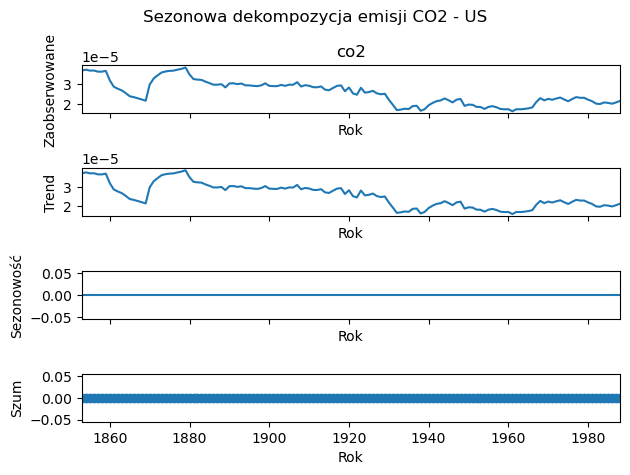

In [5]:
#Check seasonal
df_us = pd.concat([x_train_df, y_train_df['co2']], axis=1)
df_us = df_us[df_us['country_index'] == 'Stany Zjednoczone'].copy()
df_us.index = pd.to_datetime(df_us.index, format='%Y')

# Perform seasonal decomposition
result = seasonal_decompose(df_us['co2'])
fig = result.plot()

fig.axes[0].set_ylabel('Zaobserwowane')  # Observed
fig.axes[1].set_ylabel('Trend')  # Trend
fig.axes[2].set_ylabel('Sezonowość')  # Seasonality
fig.axes[3].set_ylabel('Szum')  # Residuals
for ax in fig.axes: 
    ax.set_xlabel('Rok')
fig.suptitle('Sezonowa dekompozycja emisji CO2 - US', fontsize=12)  # Overall title

# Show the plot
plt.tight_layout()
plt.show()


In [6]:
# Check stationarity
def adf_test(series,title=''):

    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string()) 
    
    if result[1] <= 0.05:
        print("Data are stationary")
    else:
        print("Data are non-stationary")

adf_test(df_us['co2'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.089095
p-value                   0.719401
# lags used              10.000000
# observations          125.000000
critical value (1%)      -3.483779
critical value (5%)      -2.884954
critical value (10%)     -2.579257
Data are non-stationary


In [7]:
# Check stationarity on first-differenced data
adf_test(df_us['co2'].diff(1))

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.477439e+00
p-value                 1.320383e-08
# lags used             9.000000e+00
# observations          1.250000e+02
critical value (1%)    -3.483779e+00
critical value (5%)    -2.884954e+00
critical value (10%)   -2.579257e+00
Data are stationary


## Hyperparameter optimization

In [8]:
# Dictionary to store the models and parameters for each country
auto_arima_models = {}

countries = x_train_df['country_index'].unique()

for country in countries:
    x_train_country = x_train_df[x_train_df['country_index'] == country].drop(columns=['country_index', 'country_order'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2']

    auto_model = pm.auto_arima(y_train_country, 
                               exogenous=x_train_country,
                               start_p=1, 
                               start_q=1,
                               max_p=5, 
                               max_q=5, 
                               seasonal=False,
                               d=1,  
                               trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    
    auto_arima_models[country] = {
        'order': auto_model.order,
    }

auto_arima_models

{'Stany Zjednoczone': {'order': (0, 1, 0)},
 'Chiny': {'order': (0, 1, 0)},
 'Rosja': {'order': (0, 1, 0)},
 'Brazylia': {'order': (0, 1, 0)},
 'Indie': {'order': (0, 1, 0)},
 'Niemcy': {'order': (0, 1, 0)},
 'Indonezja': {'order': (0, 1, 0)},
 'Wielka Brytania': {'order': (0, 1, 0)},
 'Kanada': {'order': (0, 1, 0)},
 'Japonia': {'order': (0, 1, 0)},
 'Ukraina': {'order': (0, 1, 0)},
 'Meksyk': {'order': (0, 1, 0)},
 'Francja': {'order': (0, 1, 0)},
 'Australia': {'order': (0, 1, 0)},
 'Republika Południowej Afryki': {'order': (0, 1, 0)},
 'Polska': {'order': (0, 1, 0)},
 'Włochy': {'order': (0, 1, 0)},
 'Kolumbia': {'order': (0, 1, 0)},
 'Tajlandia': {'order': (0, 1, 0)},
 'Demokratyczna Republika Konga': {'order': (0, 1, 0)},
 'Argentyna': {'order': (0, 1, 0)},
 'Iran': {'order': (0, 1, 0)},
 'Malezja': {'order': (0, 1, 0)},
 'Kazachstan': {'order': (0, 1, 0)},
 'Arabia Saudyjska': {'order': (0, 1, 0)},
 'Turcja': {'order': (0, 1, 0)},
 'Hiszpania': {'order': (0, 1, 0)},
 'Korea Połu

## Initialize the model

In [9]:
sarimax_models = {}

for country in countries:
    x_train_country = x_train_df[x_train_df['country_index'] == country].drop(columns=['country_index', 'country_order'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2']
    
    order = auto_arima_models[country]['order']
    
    model = sm.tsa.SARIMAX(y_train_country, 
                           exog=x_train_country, 
                           order=order, 
                           enforce_invertibility=False)
    results = model.fit(disp=False)

    sarimax_models[country] = {
        'model': model,
        'results': results,
        'summary': results.summary()
    }

forecast_model_path = os.path.join(config.models_folder, f'{variant_co2}_arimax_best_model.pkl')
with open(forecast_model_path, 'wb') as file:
    pickle.dump(sarimax_models, file)

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An u

## Prediction on train data

In [10]:
results_train_list = []

for country in countries:
    x_train_country = x_train_df[x_train_df['country_index'] == country].drop(columns=['country_index', 'country_order'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2']

    results_train = sarimax_models[country]['results']

    y_pred = results_train.predict(
        start=0,
        end=len(y_train_country) - 1,
        exog=x_train_country
    )

    df_results = pd.DataFrame({
        'year': x_train_country.index,
        'country': country,
        'co2_predicted': y_pred.values,
        'co2_actual': y_train_country.values
    })

    results_train_list.append(df_results)

population_df = pd.read_csv(os.path.join(config.output_cleaned, 'population_data.csv'))
population_df = population_df.rename(columns={'country_index': 'country'})

final_results_train_df = pd.concat(results_train_list, ignore_index=True)

train_df_with_population = final_results_train_df.merge(
    population_df[['year', 'country', 'population']],
    on=['year', 'country'],
    how='left'
)

train_df_with_population['co2_predicted'] = train_df_with_population['co2_predicted'] * train_df_with_population['population']
train_df_with_population['co2_actual'] = train_df_with_population['co2_actual'] * train_df_with_population['population']
train_df_with_population = train_df_with_population.drop(columns=['population'])

train_df_with_population.to_csv(os.path.join(config.predictions_arimax_standard, f'{variant_co2}_train.csv'))

## Prediction on test data

In [11]:
results_test_list = []

for country in countries:
    x_test_country = x_test_df[x_test_df['country_index'] == country].drop(columns=['country_index', 'country_order'])
    y_test_country = y_test_df[y_test_df['country_index'] == country]['co2']
    
    x_train_country = x_train_df[x_train_df['country_index'] == country].drop(columns=['country_index', 'country_order'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2']

    results_test = sarimax_models[country]['results']

    y_pred = results_test.predict(
        start=len(y_train_country),
        end=len(y_train_country) + len(x_test_country) - 1,
        exog=x_test_country
    )

    df_results = pd.DataFrame({
        'year': x_test_country.index,
        'country': country,
        'co2_predicted': y_pred.values,
        'co2_actual': y_test_country.values
    })

    results_test_list.append(df_results)

final_results_test_df = pd.concat(results_test_list, ignore_index=True)

test_df_with_population = final_results_test_df.merge(
    population_df[['year', 'country', 'population']],
    on=['year', 'country'],
    how='left'
)

test_df_with_population['co2_predicted'] = test_df_with_population['co2_predicted'] * test_df_with_population['population']
test_df_with_population['co2_actual'] = test_df_with_population['co2_actual'] * test_df_with_population['population']
test_df_with_population = test_df_with_population.drop(columns=['population'])

test_df_with_population.to_csv(os.path.join(config.predictions_arimax_standard, f'{variant_co2}_test.csv'))

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index wi

In [12]:
current_model = "arimax"

global_csv_path = os.path.join(config.predictions, f'combined_results_{variant_co2}.csv')
global_results = GlobalResults(global_csv_path, keys=["country", "year", "set"])

train = train_df_with_population.copy()
test = test_df_with_population.copy()

if "year" not in train.columns:
    train = train.reset_index()
if "year" not in test.columns:
    test = test.reset_index()

train["set"] = "train"
test["set"] = "test"

train = train.rename(columns={
    "co2_predicted": f"co2_predicted_{current_model}",
    "co2_actual": f"co2_actual_{current_model}"
})
test = test.rename(columns={
    "co2_predicted": f"co2_predicted_{current_model}",
    "co2_actual": f"co2_actual_{current_model}"
})

new_results_df = pd.concat([train, test], axis=0)
new_results_df = new_results_df.sort_values(by=["year", "country", "set"])

global_results.append_results(new_results_df)

## Charts

In [13]:
charts = ModelCharts(train_df_with_population, test_df_with_population)

#Line plot
charts.generate_line_plot(variant = variant_co2, model_output_file=config.predictions_arimax_standard)
charts.generate_line_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_arimax_standard, dataset_type='train')
charts.generate_line_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_arimax_standard, dataset_type='test')

#Scatter plot
charts.generate_scatter_plot(variant = variant_co2, model_output_file=config.predictions_arimax_standard)
charts.generate_scatter_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_arimax_standard, dataset_type='train')
charts.generate_scatter_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_arimax_standard, dataset_type='test')

## Metrics

In [14]:
evaluator = PredictionEvaluator()
evaluator.evaluate(train_df_with_population, test_df_with_population, actual_col='co2_actual', predicted_col='co2_predicted', variant = variant_co2, model_output_file=config.metrics_arimax)

## Prepare feature to hybrid model

In [15]:
#Train data
arimax_pred_train_df = final_results_train_df[['country', 'year']].copy()  # Include necessary columns
arimax_pred_train_df['arimax_pred'] = final_results_train_df['co2_predicted']
arimax_pred_train_df.to_csv(os.path.join(config.output_cleaned_hybrid, f'arimax_lstm/{variant_co2}/arimax_pred_train.csv'), index=False)

In [16]:
#Test data
arimax_pred_test_df = final_results_test_df[['country', 'year']].copy()  # Include necessary columns
arimax_pred_test_df['arimax_pred'] = final_results_test_df['co2_predicted']
arimax_pred_test_df.to_csv(os.path.join(config.output_cleaned_hybrid, f'arimax_lstm/{variant_co2}/arimax_pred_test.csv'), index=False)